# Install necessary libraries



In [1]:
!pip install nltk
!pip install contractions

In [3]:
import nltk
import re
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, matthews_corrcoef

In [32]:
#Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Collection

In [5]:
#load dataset
review = pd.read_csv("/content/reviews.csv")

In [6]:
original_len = len(review)
print(original_len)

107018


In [7]:
#dataset into dataframe
data = pd.DataFrame(review)
print(data.head())
print(data.shape)

   Id                                             Review  Label
0   0                               good and interesting      5
1   1  This class is very helpful to me. Currently, I...      5
2   2  like!Prof and TAs are helpful and the discussi...      5
3   3  Easy to follow and includes a lot basic and im...      5
4   4  Really nice teacher!I could got the point eazl...      4
(107018, 3)


In [8]:
#change column name
data.rename(columns={'Label':'Rating'}, inplace=True)

In [9]:
data.columns

Index(['Id', 'Review', 'Rating'], dtype='object')

# Data Preprocessing

In [10]:
#checking nulls
data.isnull().sum()

,0
Id,0
Review,0
Rating,0


In [11]:
#Check class distribution before preprocessing
data['Rating'].value_counts(normalize=False).sort_index()

,count
Rating,
1,2469
2,2251
3,5071
4,18054
5,79173


In [12]:
#Review lengths
data['Review_len'] = data['Review'].str.len()
data['Review_len'].describe()
print("Minimum review length:", data['Review_len'].min())

Minimum review length: 1


In [13]:
#Remove duplicates based on text and review
data = data.drop_duplicates(subset=["Review","Rating"], keep="first")
print("Shape after removing duplicates:", data.shape)

Shape after removing duplicates: (100472, 4)


In [14]:
#Remove extremely short reviews (keep text length >= 3)
data = data[data['Review_len'] >= 3]
print("Shape after removing very short reviews:", data.shape)

Shape after removing very short reviews: (100465, 4)


In [15]:
#Detect language of each review using langid
!pip install langid
import langid
#Create a new column with language code
data['lang'] = data['Review'].apply(lambda x: langid.classify(x)[0])
#Check distribution of languages
data['lang'].value_counts().head()

,count
lang,
en,99171
it,215
de,183
es,175
fr,156


In [16]:
#Keep only English reviews
data = data[data['lang'] == 'en']
print("Shape after keeping only English reviews:", data.shape)
#Drop the 'lang' column
data = data.drop(columns=['lang'])

Shape after keeping only English reviews: (99171, 5)


In [17]:
#Final class distribution
data['Rating'].value_counts().sort_index()

,count
Rating,
1,2382
2,2209
3,4984
4,17398
5,72198


In [18]:
data.drop(columns="Id", inplace=True)

In [19]:
#Summary of preprocessing
summary = {
    "Total Reviews After Preprocessing": [len(data)],
    "Duplicates Removed": [len(data) - len(data.drop_duplicates(subset="Review", keep="first"))],
}
pd.DataFrame(summary)

,Total Reviews After Preprocessing,Duplicates Removed
0,99171,414


# Exploratory Data Analysis

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99171 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      99171 non-null  object
 1   Rating      99171 non-null  int64 
 2   Review_len  99171 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.0+ MB


In [21]:
#basic statistics
data.describe()

,Rating,Review_len
count,99171.000000,99171.000000
mean,4.561152,156.027266
std,0.876732,192.259708
min,1.000000,3.000000
25%,4.000000,52.000000
50%,5.000000,98.000000
75%,5.000000,190.000000
max,5.000000,7766.000000


In [22]:
data.head(10)

,Review,Rating,Review_len
0,good and interesting,5,20
1,"This class is very helpful to me. Currently, I...",5,121
2,like!Prof and TAs are helpful and the discussi...,5,117
3,Easy to follow and includes a lot basic and im...,5,81
4,Really nice teacher!I could got the point eazl...,4,58
5,"Great course - I recommend it for all, especia...",5,75
6,One of the most useful course on IT Management!,5,47
7,I was disappointed because the name is mislead...,3,381
8,Super content. I'll definitely re-do the course,5,47
9,One of the excellent courses at Coursera for i...,5,88


In [23]:
data['Review_len'] = data['Review'].str.split().str.len()
#Rating distribution
print(data['Rating'].value_counts(normalize=True))

Rating
5    0.728015
4    0.175434
3    0.050257
1    0.024019
2    0.022275
Name: proportion, dtype: float64


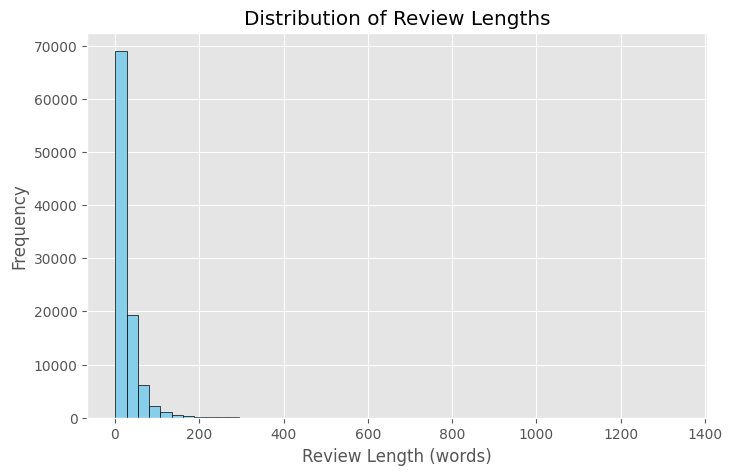

In [24]:
#review length distribution
#Histogram
plt.figure(figsize=(8,5))
plt.hist(data['Review_len'], bins=50, color='Skyblue', edgecolor='black')
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

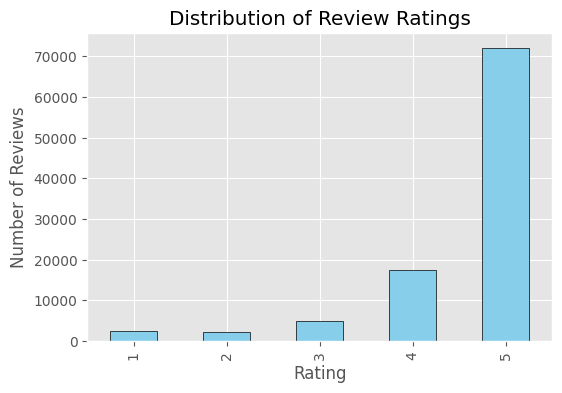

In [25]:
#Bar plot of rating frequencies
data['Rating'].value_counts().sort_index().plot(kind='bar', figsize=(6,4), color='skyblue', edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Ratings")
plt.show()

In [26]:
#review length by label
data.groupby('Rating')['Review_len'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,2382.0,50.641898,61.136381,1.0,14.0,30.0,62.0,571.0
2,2209.0,54.590312,65.186988,1.0,16.0,33.0,69.0,857.0
3,4984.0,41.017055,52.123800,1.0,13.0,25.0,50.0,1041.0
4,17398.0,29.400506,36.013005,1.0,10.0,19.0,37.0,1338.0
5,72198.0,23.074393,25.941274,1.0,8.0,15.0,29.0,1193.0


In [27]:
#detecting extreme cases
#Very short reviews (≥3 but <10 chars)
data[data['Review_len'] < 10].head()

,Review,Rating,Review_len
0,good and interesting,5,3
6,One of the most useful course on IT Management!,5,9
8,Super content. I'll definitely re-do the course,5,7
11,Excellent course and teachers. Congratulations!!,5,5
14,Very structured approach. Thank you for sharin...,5,9


In [28]:
#Very long reviews (>1000 chars)
data[data['Review_len'] > 1000].head()

,Review,Rating,Review_len
330,This is my feedback as a Beta-Tester for the c...,4,1338
6607,(I posted this review in a blog [https://guhya...,3,1041
10697,This is a great course and a daring venture fo...,4,1098
10818,"I will try now a Summary of the whole course, ...",5,1193


# Text Preprocessing for Multinomial Naives Bayes

In [29]:
#Initialize preproces
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [30]:
#function for all preprocessing
def preprocess_text(text):
  text = text.lower() #lower case (case folding)
  text = contractions.fix(text) #Expanding contractions
  text = re.sub(r'[^\w\s]', '', text) #Punctuation removal
  tokens = nltk.word_tokenize(text) #tokenize
  tokens = [word for word in tokens if word not in stop_words] #Remove stopwords
  tokens = [lemmatizer.lemmatize(word) for word in tokens] #Lemmatization
  return ' '.join(tokens) #Return cleaned text as a string

In [33]:
data['Clean_Review'] = data['Review'].apply(preprocess_text)

In [34]:
#Original vs Cleaned
data[['Review','Clean_Review']].sample(5)

,Review,Clean_Review
44543,Must for anybody like human,must anybody like human
32957,Good course focusing on best practice and sema...,good course focusing best practice semantics
37478,"Great course for ""brushing up"" on basic web de...",great course brushing basic web design really ...
51483,"Great course, I've learned a whole lot!",great course learned whole lot
39377,The Importance of Listening is a great course ...,importance listening great course providing ha...


# Text Mining

In [35]:
#generating most frequent words
#Combine all cleaned reviews
all_words = ' '.join(data['Clean_Review']).split()
#Count word frequencies
word_freq = Counter(all_words)
#Top 20 frequent words
word_freq.most_common(20)

[('course', 83856),
 ('great', 22683),
 ('good', 19926),
 ('really', 13765),
 ('learning', 11141),
 ('lot', 10976),
 ('well', 10263),
 ('would', 9376),
 ('excellent', 9052),
 ('learn', 8543),
 ('interesting', 8386),
 ('much', 8074),
 ('assignment', 7440),
 ('like', 7203),
 ('material', 7078),
 ('thank', 7029),
 ('one', 7001),
 ('way', 6943),
 ('easy', 6627),
 ('useful', 6579)]

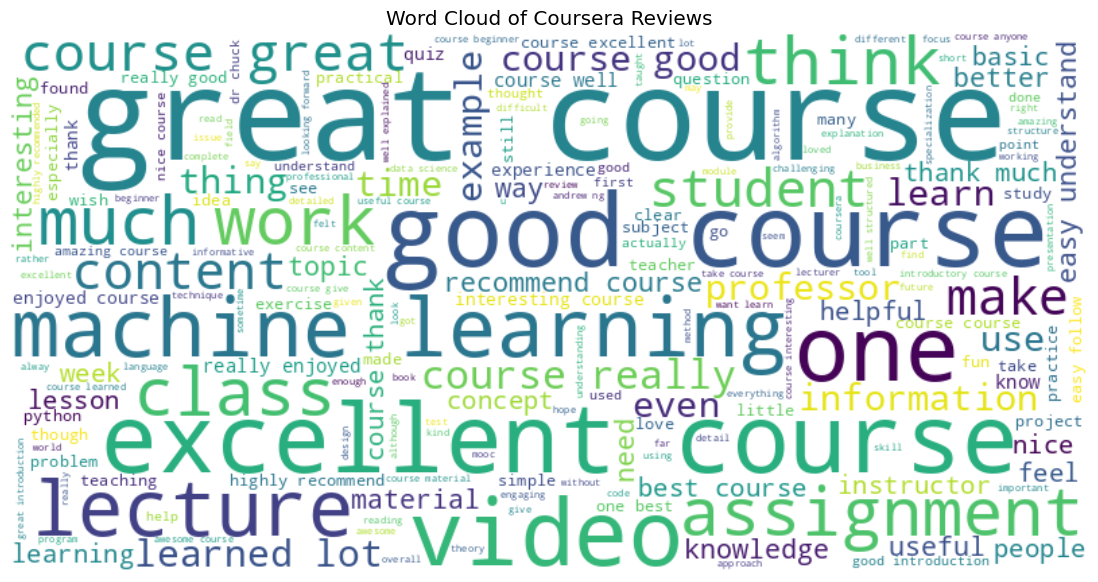

In [36]:
#Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['Clean_Review']))
#Plot
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Coursera Reviews")
plt.show()

In [37]:
#Bigrams (2-words phrase)
#Generate bigrams
all_bigrams = list(ngrams(all_words, 2))
bigram_freq = Counter(all_bigrams)
#Top 20 bigrams
bigram_freq.most_common(20)

[(('great', 'course'), 7518),
 (('good', 'course'), 4185),
 (('excellent', 'course'), 3707),
 (('machine', 'learning'), 3400),
 (('course', 'great'), 2651),
 (('course', 'really'), 2286),
 (('learned', 'lot'), 2178),
 (('course', 'good'), 2000),
 (('recommend', 'course'), 1817),
 (('easy', 'understand'), 1798),
 (('best', 'course'), 1595),
 (('thank', 'much'), 1490),
 (('really', 'enjoyed'), 1404),
 (('course', 'well'), 1387),
 (('interesting', 'course'), 1374),
 (('enjoyed', 'course'), 1361),
 (('highly', 'recommend'), 1349),
 (('easy', 'follow'), 1251),
 (('really', 'good'), 1250),
 (('course', 'excellent'), 1185)]

In [38]:
#Trigrams (3-words phrase)
#Generate trigrams
all_trigrams = list(ngrams(all_words, 3))
trigram_freq = Counter(all_trigrams)
trigram_freq.most_common(20)

[(('one', 'best', 'course'), 606),
 (('really', 'enjoyed', 'course'), 583),
 (('course', 'learned', 'lot'), 533),
 (('highly', 'recommend', 'course'), 533),
 (('course', 'great', 'course'), 499),
 (('recommend', 'course', 'anyone'), 417),
 (('great', 'course', 'great'), 395),
 (('best', 'course', 'ever'), 380),
 (('would', 'recommend', 'course'), 367),
 (('really', 'good', 'course'), 353),
 (('course', 'excellent', 'course'), 309),
 (('introduction', 'machine', 'learning'), 307),
 (('learned', 'lot', 'course'), 305),
 (('machine', 'learning', 'course'), 294),
 (('course', 'good', 'course'), 285),
 (('good', 'introductory', 'course'), 276),
 (('course', 'machine', 'learning'), 273),
 (('would', 'highly', 'recommend'), 256),
 (('great', 'course', 'really'), 245),
 (('great', 'course', 'learned'), 236)]

# Sentiment Labeling Using a Sentiment Dictionary

In [39]:
# Install VADER
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [40]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
      return "negative"
    else:
        return "neutral"

#apply to exisiting dataset
data["sentiment"] = data["Review"].apply(get_sentiment)
data["sentiment"].value_counts()

,count
sentiment,
positive,88190
neutral,6116
negative,4865


# Undersample majority class - reducing positive reviews

In [47]:
from sklearn.utils import resample
#Split into separate classes
positive = data[data['sentiment'] == 'positive']
negative = data[data['sentiment'] == 'negative']
neutral  = data[data['sentiment'] == 'neutral']

#Find the smallest class size
min_size = min(len(positive), len(negative), len(neutral))

#Downsample positive class to the minimum size
positive_down = resample(positive, replace=False, n_samples=min_size, random_state=42)

#Combine into balanced dataset
data_balanced = pd.concat([positive_down, negative, neutral])

In [48]:
data_balanced["sentiment"].value_counts()

,count
sentiment,
neutral,6116
positive,4865
negative,4865


# Modelling - Naive Bayes

In [49]:
#dataset was divided into a training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data_balanced["Clean_Review"],
    data_balanced["sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=data_balanced["sentiment"]
)

In [50]:
#Convert text to TFIDF features
tfidf = TfidfVectorizer(stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [51]:
#Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

# Evaluation of the Model

In [58]:
y_pred = nb.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))

#Macro
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7930599369085174
Cohen's Kappa: 0.6892833444176207
MCC: 0.6910585126417701
F1 Score: 0.7930599369085174
Macro Precision: 0.793517586888921
Macro Recall: 0.7949360399635473
Macro F1: 0.792350450737929


In [54]:
#Full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    negative       0.71      0.79      0.75       973
     neutral       0.87      0.77      0.82      1224
    positive       0.80      0.82      0.81       973

    accuracy                           0.79      3170
   macro avg       0.79      0.79      0.79      3170
weighted avg       0.80      0.79      0.79      3170




Confusion Matrix:
 [[771  93 109]
 [192 944  88]
 [128  46 799]]


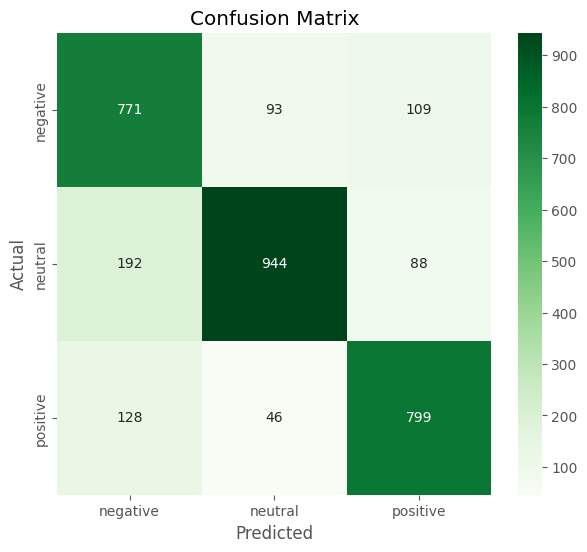

In [56]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
print("\nConfusion Matrix:\n", cm)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()